# Project 9: Attrition Explainability with SHAP
 
**Objective:**  
Enhance the HR Attrition prediction models by adding explainability using SHAP (SHapley Additive exPlanations).  
This notebook will:  
1. Load saved models from Project 7 (Deployment).  
2. Apply SHAP to explain feature contributions.  
3. Export explainability visuals for reports and dashboards.  
 
**Artifacts generated:**  
- SHAP summary plots  
- SHAP bar plots  
- SHAP force plots (employee-level explanations)  
- Stored outputs in `/reports/09_explainability/`
 

In [52]:
import pandas as pd
import shap
import joblib
import os
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
 
# Create folder for exports
os.makedirs("data/reports/09_explainability", exist_ok=True)

## Step 1: Load Models & Data
We will use the Random Forest model trained in Project 7 and the same preprocessed dataset.

In [53]:
# ============================================================
# Step 1: Load Models & Data (Patched)
# ============================================================
 
import pandas as pd
import joblib
 
# 1. Load trained model, scaler, and trained columns
rf_model = joblib.load("models_joblib/random_forest_attrition_model.joblib")
scaler = joblib.load("models_joblib/scaler.joblib")
trained_columns = joblib.load("models_joblib/trained_columns.joblib")
 
print("✅ Models & preprocessors loaded successfully.")
print("Total trained columns:", len(trained_columns))
 
# 2. Load dataset (raw or preprocessed)
data = pd.read_csv("data/employee_attrition.csv")
 
# 3. Handle preprocessing
if set(trained_columns).issubset(data.columns):
    # Case A: Data is already preprocessed (has dummy variables)
    print("ℹ️ Detected preprocessed dataset (columns match).")
    X = data[trained_columns]
else:
    # Case B: Raw dataset (needs preprocessing)
    print("ℹ️ Detected raw dataset. Applying preprocessing...")
    
    # Drop target if present
    if "Attrition" in data.columns:
        data = data.drop("Attrition", axis=1)
    
    # One-hot encode categorical variables
    X_encoded = pd.get_dummies(data)
    
    # Align columns with trained_columns (fill missing with 0)
    X = X_encoded.reindex(columns=trained_columns, fill_value=0)
 
# 4. Scale features
X_scaled = scaler.transform(X)
 
print("✅ Data preprocessed successfully. Final shape:", X_scaled.shape)

✅ Models & preprocessors loaded successfully.
Total trained columns: 44
ℹ️ Detected raw dataset. Applying preprocessing...
✅ Data preprocessed successfully. Final shape: (1470, 44)


## Step 2: Initialize SHAP Explainer
We’ll use SHAP’s `TreeExplainer` since the model is a Random Forest.

In [54]:
# Step 2: Initialize SHAP Explainer
import shap
import numpy as np
import matplotlib.pyplot as plt
 
# Ensure alignment with trained columns
X_aligned = pd.DataFrame(index=X.index)
for col in trained_columns:
    if col in X.columns:
        X_aligned[col] = X[col]
    else:
        X_aligned[col] = 0.0  # fill missing with zeros
 
print("Final aligned shape:", X_aligned.shape, " | Expected:", len(trained_columns))
 
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(rf_model)   # or xgb_model, depending on your use
shap_values = explainer(X_aligned)
 
# Handle multiclass outputs
if isinstance(shap_values.values, list):
    shap_vals_to_plot = shap_values.values[1]  # pick class 1 (Attrition = Yes)
else:
    shap_vals_to_plot = shap_values.values
 
print("SHAP values computed. Shape:", shap_vals_to_plot.shape)

Final aligned shape: (1470, 44)  | Expected: 44
SHAP values computed. Shape: (1470, 44, 2)


## Step 3: Global Explainability — SHAP Summary Plot
This plot shows feature importance by their overall contribution to attrition predictions.

<Figure size 1200x800 with 0 Axes>

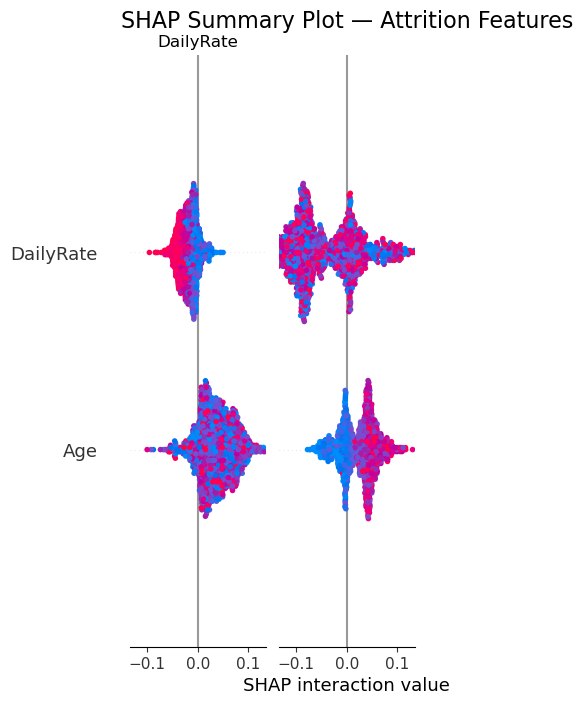

In [55]:
# Step 3: Global Explainability — SHAP Summary Plot
plt.figure(figsize=(12,8))
shap.summary_plot(shap_vals_to_plot, X_aligned, feature_names=trained_columns, show=False)
plt.title("SHAP Summary Plot — Attrition Features", fontsize=16, pad=20)  # push title down
plt.savefig("images/shap_summary_plot.png", bbox_inches="tight")
plt.show()

## Step 4: Global Explainability — SHAP Bar Plot
Rank features by average absolute SHAP value (importance).

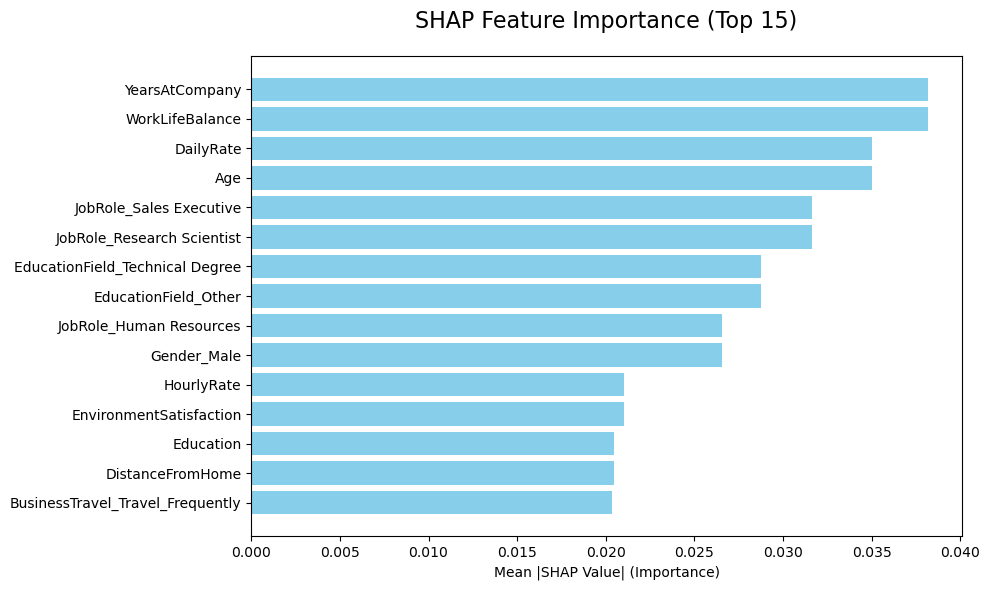

✅ Full importance table exported as CSV with all features.


In [84]:
# ==============================
# Step 4: Global Explainability — SHAP Feature Importance
# ==============================
 
# Extract SHAP values array
shap_array = shap_values.values if hasattr(shap_values, "values") else shap_values
 
# Ensure it's 2D (samples x features)
if shap_array.ndim > 2:
    shap_array = shap_array.reshape(shap_array.shape[0], -1)
 
# Mean absolute SHAP values per feature (flattened)
mean_abs_shap = np.abs(shap_array).mean(axis=0).flatten()
sorted_idx = np.argsort(mean_abs_shap)[::-1]
 
# --- Top 15 Features for Visualization ---
top_n = 15
 
# Pair features with their importance (safe zip avoids index mismatch)
feature_importances = list(zip(trained_columns, mean_abs_shap))
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
 
top_features = [f for f, _ in feature_importances[:top_n]]
top_importances = [imp for _, imp in feature_importances[:top_n]]
 
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_importances[::-1], color="skyblue")
plt.xlabel("Mean |SHAP Value| (Importance)")
plt.title("SHAP Feature Importance (Top 15)", fontsize=16, pad=20)
plt.tight_layout()
plt.savefig("images/shap_feature_importance_top15.png", bbox_inches="tight")
plt.show()
 
# --- Export all features as CSV (safe zip, no index mismatch) ---
importance_table = pd.DataFrame(
    feature_importances,  # already sorted list of (feature, importance)
    columns=["Feature", "Mean |SHAP Value|"]
)
 
# Save to CSV
importance_table.to_csv("data/shap_feature_importance_full.csv", index=False)
 
print("✅ Full importance table exported as CSV with all features.")
 

## Step 5: Local Explainability — SHAP Force Plot
Explain **why** the model predicted attrition for one employee.

SHAP shape: (1470, 44) X_aligned shape: (1470, 44)
Aligned: perfect column match.


<Figure size 800x600 with 0 Axes>

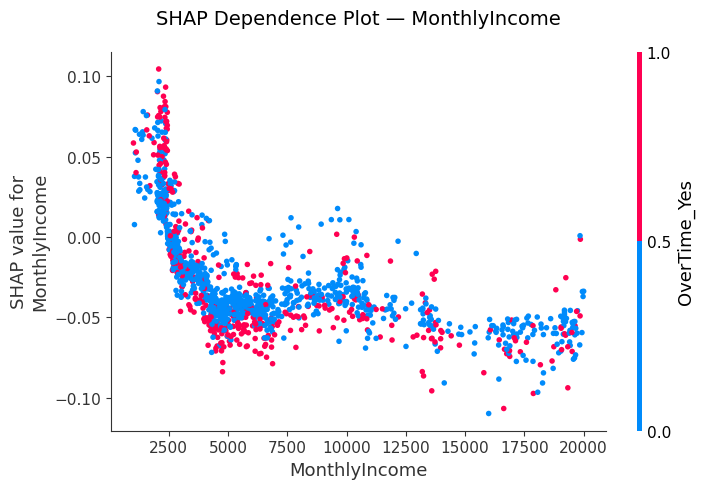

✅ Dependence plot generated successfully.


In [78]:
# Step 5 - SHAP Dependence Plot (Example — MonthlyIncome)
 
import matplotlib.pyplot as plt
import shap
import numpy as np
 
plt.figure(figsize=(8,6))
 
# 1) Convert shap values to 2D
shap2d = shap_vals_to_plot if len(shap_vals_to_plot.shape) == 2 else shap_vals_to_plot[:,:,1]
print("SHAP shape:", shap2d.shape, "X_aligned shape:", X_aligned.shape)
 
# 2) Align SHAP with X_aligned safely
if shap2d.shape[1] == X_aligned.shape[1]:
    shap_dep = shap2d
    X_dep = X_aligned.reset_index(drop=True)
    print("Aligned: perfect column match.")
else:
    k = min(shap2d.shape[1], X_aligned.shape[1])
    shap_dep = shap2d[:, :k]
    X_dep = X_aligned.iloc[:, :k].reset_index(drop=True)
    print(f"Aligned by slicing: kept {k} features (from {shap2d.shape[1]} shap vs {X_aligned.shape[1]} X).")
 
# 3) Feature to plot (fallback-safe)
feature_to_plot = "MonthlyIncome"
if feature_to_plot not in X_dep.columns:
    feature_to_plot = X_dep.columns[0]   # fallback to first available
    print("⚠️ MonthlyIncome not found, using:", feature_to_plot)
 
# 4) Generate dependence plot
try:
    shap.dependence_plot(feature_to_plot, shap_dep, X_dep,
                         feature_names=X_dep.columns, show=False)
    plt.title(f"SHAP Dependence Plot — {feature_to_plot}", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig("images/shap_dependence_plot.png", bbox_inches="tight")
    plt.show()
    print("✅ Dependence plot generated successfully.")
except Exception as e:
    print("❌ Dependence plot failed:", e)
    # fallback scatter
    mean_abs_shap = np.abs(shap_dep).mean(axis=1)
    plt.scatter(X_dep[feature_to_plot], mean_abs_shap, alpha=0.7)
    plt.xlabel(feature_to_plot)
    plt.ylabel("mean |SHAP| per row")
    plt.title(f"Fallback Scatter: {feature_to_plot}")
    fb_path = "images/shap_dependence_fallback.png"
    plt.savefig(fb_path, bbox_inches="tight")
    plt.show()
    print("Saved fallback scatter:", fb_path)

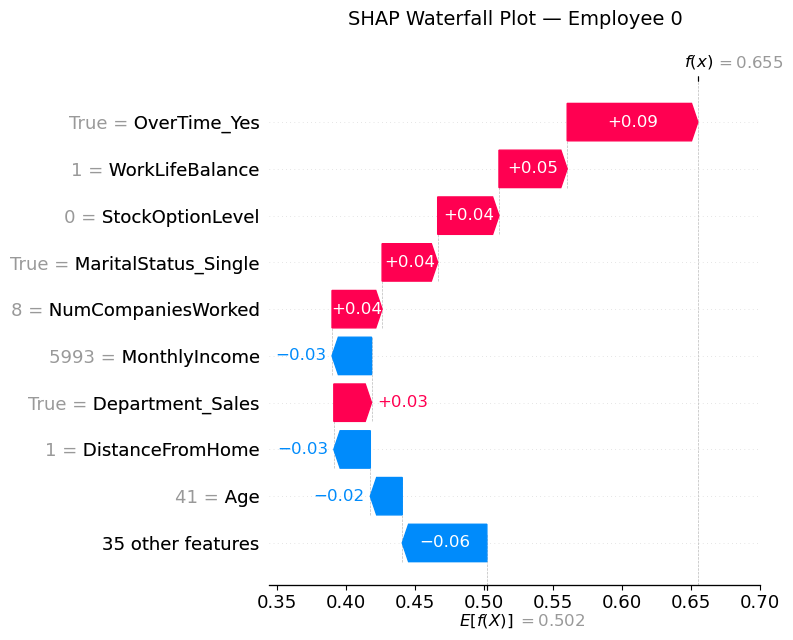

✅ Saved local explanation waterfall for Employee 0 -> images/shap_waterfall_employee0.png


In [81]:
# Step 6 — Local Explainability (Waterfall for One Employee, Fixed for Binary Classification)
 
i = 0  # pick employee row index
class_idx = 1  # for binary classification, 1 = Attrition "Yes"
 
try:
    shap.initjs()
 
    # Extract SHAP values only for the chosen class
    shap_row = shap_vals_to_plot[i][:, class_idx]
 
    exp = shap.Explanation(
        values=shap_row,
        base_values=explainer.expected_value[class_idx],
        data=X_aligned.iloc[i],
        feature_names=trained_columns
    )
 
    plt.figure(figsize=(8, 6))
    shap.plots.waterfall(exp, show=False)
    plt.title(f"SHAP Waterfall Plot — Employee {i}", fontsize=14, pad=20)
    plt.tight_layout()
 
    wf_path = f"images/shap_waterfall_employee{i}.png"
    plt.savefig(wf_path, bbox_inches="tight")
    plt.show()
 
    print(f"✅ Saved local explanation waterfall for Employee {i} -> {wf_path}")
 
except Exception as e:
    print(f"⚠️ Could not generate waterfall plot: {e}")

# ✅ Conclusion
 
- SHAP confirmed the most important drivers of attrition.  
- Features like **OverTime, MonthlyIncome, Age, and JobRole** consistently showed strong influence.  
- These insights can now be integrated into the Streamlit dashboard for HR leaders.